https://github.com/JL3s/7318_Assignment1

### 0.1 Device agnostic check

In [465]:
# Device
import torch
print(f"GPU: {torch.cuda.is_available()}")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

GPU: False
device: cpu


In [466]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


### 1.1 Import data - scaled[-1,1]{output:1,0}

In [467]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt

file_out = pd.read_excel("diabetes_scaled(0,1).xlsx")
#file_out = pd.read_excel("diabetes.xlsx")


file_out.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-0.294118,0.487437,0.180328,-0.292929,-1.000000,0.001490,-0.531170,-0.033333,1
1,-0.882353,-0.145729,0.081967,-0.414141,-1.000000,-0.207153,-0.766866,-0.666667,0
2,-0.058824,0.839196,0.049180,-1.000000,-1.000000,-0.305514,-0.492741,-0.633333,1
3,-0.882353,-0.105528,0.081967,-0.535354,-0.777778,-0.162444,-0.923997,-1.000000,0
4,-1.000000,0.376884,-0.344262,-0.292929,-0.602837,0.284650,0.887276,-0.600000,1


In [468]:
X = file_out.iloc[0:,0:8]
y = file_out.iloc[0:,8]


In [469]:
X.head(5) , y.head(5)

(   Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
 0    -0.294118  0.487437       0.180328      -0.292929 -1.000000  0.001490   
 1    -0.882353 -0.145729       0.081967      -0.414141 -1.000000 -0.207153   
 2    -0.058824  0.839196       0.049180      -1.000000 -1.000000 -0.305514   
 3    -0.882353 -0.105528       0.081967      -0.535354 -0.777778 -0.162444   
 4    -1.000000  0.376884      -0.344262      -0.292929 -0.602837  0.284650   
 
    DiabetesPedigreeFunction       Age  
 0                 -0.531170 -0.033333  
 1                 -0.766866 -0.666667  
 2                 -0.492741 -0.633333  
 3                 -0.923997 -1.000000  
 4                  0.887276 -0.600000  ,
 0    1
 1    0
 2    1
 3    0
 4    1
 Name: Outcome, dtype: int64)

### 1.2 Splite data into training & testing

In [470]:
## set input of random_seed for reproducibility
random_seed = 7318

In [471]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20, #80%-training set, 20%-testing set
                                                    random_state=random_seed)

In [472]:
X_train = torch.tensor(X_train.to_numpy()).float()
y_train = torch.tensor(y_train.to_numpy()).float()
X_test = torch.tensor(X_test.to_numpy()).float()
y_test = torch.tensor(y_test.to_numpy()).float()

### 2.1 Create baseline model (Multilayer Perceptron)



In [473]:
import torch
from torch import nn


In [474]:
hidden_nodes = 16
learning_rate = 1e-2

In [475]:
class MLPv0(nn.Module):
  def __init__(self, hidden_nodes):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(in_features = 8, out_features = hidden_nodes),
        nn.ReLU(),
        nn.Linear(in_features = hidden_nodes, out_features = 1)
    )

  def forward(self, x: torch.Tensor):
    return self.model(x)

In [476]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred))*100
  return acc

In [477]:
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
MLP_model = MLPv0(hidden_nodes).to(device)
#MLP_model.state_dict()
MLP_model

MLPv0(
  (model): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [478]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = MLP_model.parameters(),
                            lr = learning_rate,
                            momentum= 0,
                            weight_decay=0)


In [479]:
epochs = 10000

In [480]:
from tqdm.auto import tqdm

Epochs = []
TrainLoss = []
TestLoss = []
TrainAcc =[]
TestAcc =[]

### Train loop
for epoch in tqdm(range(epochs)):

  train_loss = 0
  acc = 0

  X_train, y_train = X_train.to(device), y_train.to(device)

  MLP_model.train()
  y_logits = MLP_model(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  #train_loss += loss #accumulate train loss
  acc += accuracy_fn(y_true = y_train,
                             y_pred = y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()




  ### testing
  test_loss, test_acc = 0, 0
  MLP_model.eval()
  with torch.inference_mode():
    X_test, y_test = X_test.to(device), y_test.to(device)
    test_logits = MLP_model(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true = y_test,
                              y_pred = test_pred)


  if epoch % 500 ==499:
    print(f"Epoch: {epoch} | Train loss: {loss:.10f},Train acc: {acc:.5f} % | Test loss: {test_loss:.10f}, Test acc: {test_acc:.5f} %")

  Epochs.append(epoch)
  if device == "cpu":
    TrainLoss.append(loss.detach().numpy())
    TestLoss.append(test_loss)
  else:
    TrainLoss.append(loss.to("cpu").detach().numpy())
    TestLoss.append(test_loss.to("cpu").detach().numpy())
  TrainAcc.append(acc)
  TestAcc.append(test_acc)


  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 499 | Train loss: 0.6134775281,Train acc: 65.30945 % | Test loss: 0.6226793528, Test acc: 64.93506 %
Epoch: 999 | Train loss: 0.5777709484,Train acc: 67.10098 % | Test loss: 0.5933682919, Test acc: 67.53247 %
Epoch: 1499 | Train loss: 0.5430750847,Train acc: 71.66124 % | Test loss: 0.5654976964, Test acc: 74.02597 %
Epoch: 1999 | Train loss: 0.5157045126,Train acc: 74.75570 % | Test loss: 0.5437254310, Test acc: 74.02597 %
Epoch: 2499 | Train loss: 0.4971381128,Train acc: 75.73290 % | Test loss: 0.5279451609, Test acc: 73.37662 %
Epoch: 2999 | Train loss: 0.4852694571,Train acc: 76.54723 % | Test loss: 0.5164992213, Test acc: 72.07792 %
Epoch: 3499 | Train loss: 0.4776259363,Train acc: 76.38436 % | Test loss: 0.5078971386, Test acc: 72.72727 %
Epoch: 3999 | Train loss: 0.4724970162,Train acc: 76.54723 % | Test loss: 0.5016410351, Test acc: 74.67532 %
Epoch: 4499 | Train loss: 0.4690262973,Train acc: 76.87296 % | Test loss: 0.4971570671, Test acc: 74.67532 %
Epoch: 4999 | Train l

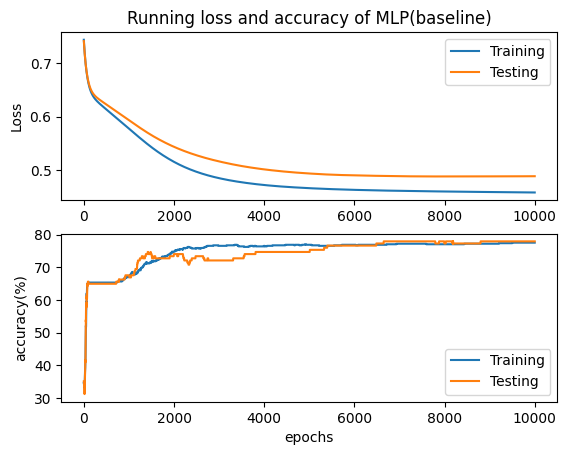

In [481]:
plt.subplot(2,1,1)
plt.plot(Epochs, TrainLoss , label="Training")
plt.plot(Epochs, TestLoss, label = "Testing")
plt.legend(loc='upper right')
#plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("Running loss and accuracy of MLP(baseline)")

plt.subplot(2,1,2)
plt.plot(Epochs, TrainAcc , label="Training")
plt.plot(Epochs, TestAcc, label = "Testing")
plt.legend(loc='lower right')
plt.xlabel("epochs")
plt.ylabel("accuracy(%)")


plt.show()

In [482]:
test_pred

tensor([0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0.,
        1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
        1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 1., 0., 0.])

In [483]:
torch.eq(y_test,test_pred)

tensor([ True,  True,  True,  True,  True,  True, False,  True,  True,  True,
        False,  True, False,  True,  True,  True, False,  True, False, False,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True, False,  True, False,  True, False,  True, False,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True, False, False,  True,  True,
         True,  True,  True,  True,  True, False, False, False,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False, False,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True, False,  True,  True,  True,  True,
        False, False,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True, False,  True,  True, False, 

In [484]:
def train_step(model,
               X_train,
               y_train,
               X_test,
               y_test,
               loss_fn,
               optimizer,
               title = "MLP(experiment)",
               epochs=10000):
  epochs = epochs

  Epochs = []
  TrainLoss = []
  TestLoss = []
  TrainAcc =[]
  TestAcc =[]

  for epoch in tqdm(range(epochs)):

    train_loss = 0
    acc = 0

    X_train, y_train = X_train.to(device), y_train.to(device)

    model.train()
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc += accuracy_fn(y_true = y_train,
                     y_pred = y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
      X_test, y_test = X_test.to(device), y_test.to(device)
      test_logits = model(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true = y_test,
                            y_pred = test_pred)


    Epochs.append(epoch)
    if device == "cpu":
      TrainLoss.append(loss.detach().numpy())
      TestLoss.append(test_loss)
    else:
      TrainLoss.append(loss.to("cpu").detach().numpy())
      TestLoss.append(test_loss.to("cpu").detach().numpy())
    TrainAcc.append(acc)
    TestAcc.append(test_acc)

  plt.subplot(2,1,1)

  plt.plot(Epochs, TrainLoss , label="Training")
  plt.plot(Epochs, TestLoss, label = "Testing")
  plt.legend(loc='upper right')
  plt.xlabel("epochs")
  plt.ylabel("Loss")
  plt.title("Running loss of "+title)
  plt.grid(True)

  plt.subplot(2,1,2)
  plt.plot(Epochs, TrainAcc , label="Training")
  plt.plot(Epochs, TestAcc, label = "Testing")
  plt.legend(loc='lower right')
  plt.xlabel("epochs")
  plt.ylabel("accuracy(%)")
  plt.title("Accuracy of "+title)
  plt.grid(True)

  plt.subplots_adjust(hspace = 0.5)

In [485]:
def model_eval(model,
               X_test,
               y_test,
               loss_fn
               ):
  model.eval()
  with torch.inference_mode():
    X_test, y_test = X_test.to(device), y_test.to(device)
    test_logits = model(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true = y_test,
                          y_pred = test_pred)

  return {"model":model.__class__.__name__,
          "model_loss": test_loss.item(),
          "model_acc": test_acc}

In [486]:
hidden_nodes_list =[16, 32, 64]
learning_rate_list = [1e-1, 1e-2, 1e-3 ]
no_of_hidden_layer = [1, 2, 3]
w_dropout_layer = [True, False]


  0%|          | 0/10000 [00:00<?, ?it/s]

{'model': 'MLPv0',
 'model_loss': 0.48890721797943115,
 'model_acc': 77.92207792207793}

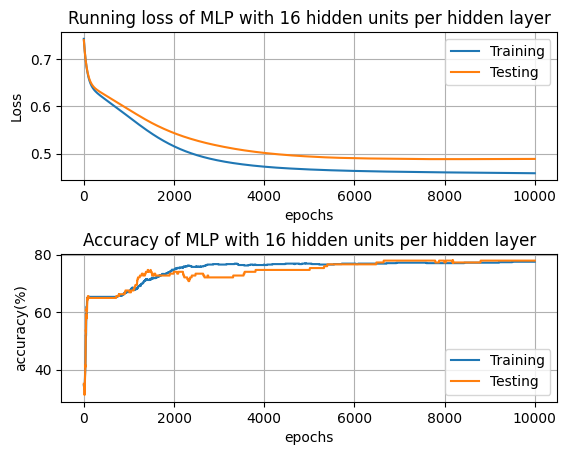

In [487]:
# hidden_nodes w/ 16
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
MLP_model1 = MLPv0(16).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = MLP_model1.parameters(),
                            lr = learning_rate,
                            momentum= 0,
                            weight_decay=0)

train_step(model=MLP_model1,
           X_train=X_train,
           y_train=y_train,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn,
           optimizer = optimizer,
           title = "MLP with 16 hidden units per hidden layer")
model_eval(model=MLP_model1,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn)


  0%|          | 0/10000 [00:00<?, ?it/s]

{'model': 'MLPv0',
 'model_loss': 0.48101356625556946,
 'model_acc': 77.27272727272727}

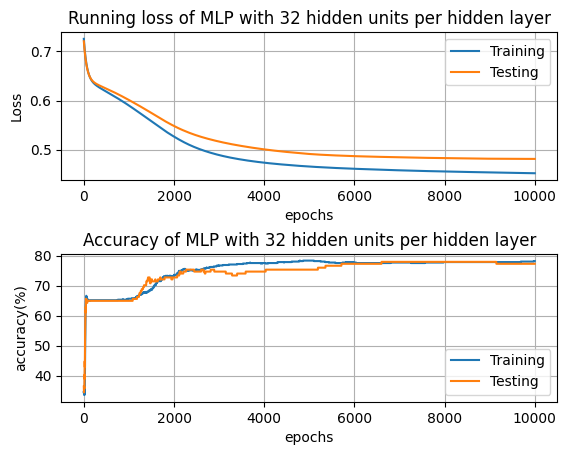

In [488]:
# hidden_nodes w/ 32
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
MLP_model2 = MLPv0(32).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = MLP_model2.parameters(),
                            lr = learning_rate,
                            momentum= 0,
                            weight_decay=0)

train_step(model=MLP_model2,
           X_train=X_train,
           y_train=y_train,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn,
           optimizer = optimizer,
           title = "MLP with 32 hidden units per hidden layer")
model_eval(model=MLP_model2,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn)


  0%|          | 0/10000 [00:00<?, ?it/s]

{'model': 'MLPv0',
 'model_loss': 0.47880658507347107,
 'model_acc': 77.27272727272727}

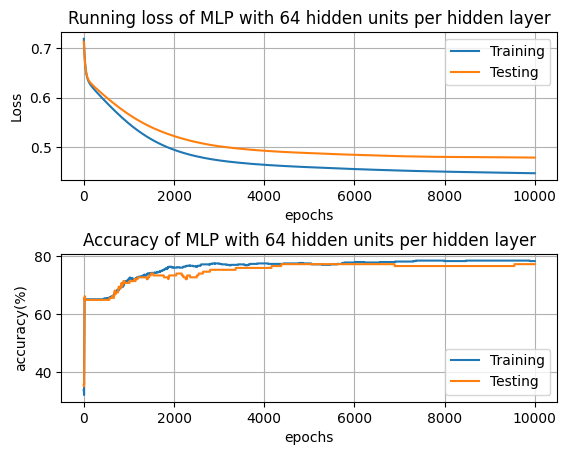

In [489]:
# hidden_nodes w/ 64
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
MLP_model3 = MLPv0(64).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = MLP_model3.parameters(),
                            lr = learning_rate,
                            momentum= 0,
                            weight_decay=0)

train_step(model=MLP_model3,
           X_train=X_train,
           y_train=y_train,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn,
           optimizer = optimizer,
           title = "MLP with 64 hidden units per hidden layer")
model_eval(model=MLP_model3,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn)




  0%|          | 0/10000 [00:00<?, ?it/s]

{'model': 'MLPv0',
 'model_loss': 0.48360246419906616,
 'model_acc': 75.97402597402598}

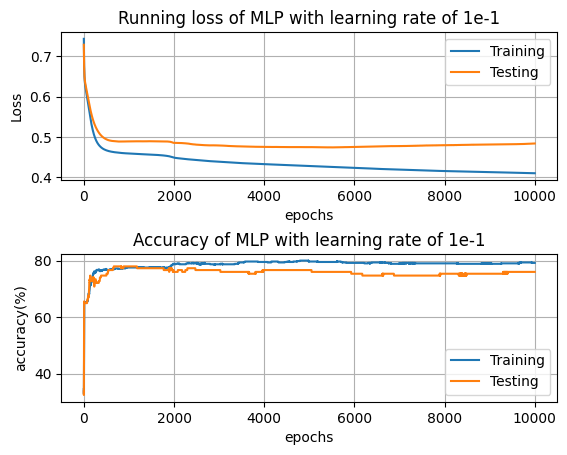

In [490]:
# learning rate w/ 1e-1
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
MLP_model4 = MLPv0(hidden_nodes).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = MLP_model4.parameters(),
                            lr = 1e-1,
                            momentum= 0,
                            weight_decay=0)

train_step(model=MLP_model4,
           X_train=X_train,
           y_train=y_train,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn,
           optimizer = optimizer,
           title = "MLP with learning rate of 1e-1")
model_eval(model=MLP_model4,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn)

  0%|          | 0/10000 [00:00<?, ?it/s]

{'model': 'MLPv0',
 'model_loss': 0.48890721797943115,
 'model_acc': 77.92207792207793}

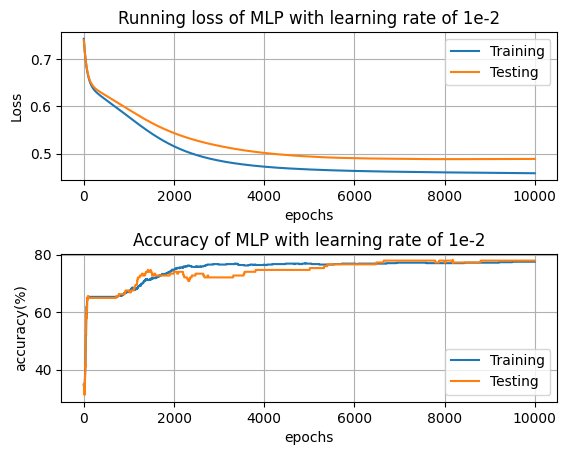

In [491]:
# learning rate w/ 1e-2
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
MLP_model5 = MLPv0(hidden_nodes).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = MLP_model5.parameters(),
                            lr = 1e-2,
                            momentum= 0,
                            weight_decay=0)

train_step(model=MLP_model5,
           X_train=X_train,
           y_train=y_train,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn,
           optimizer = optimizer,
           title = "MLP with learning rate of 1e-2")
model_eval(model=MLP_model5,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn)

  0%|          | 0/10000 [00:00<?, ?it/s]

{'model': 'MLPv0',
 'model_loss': 0.593345582485199,
 'model_acc': 67.53246753246754}

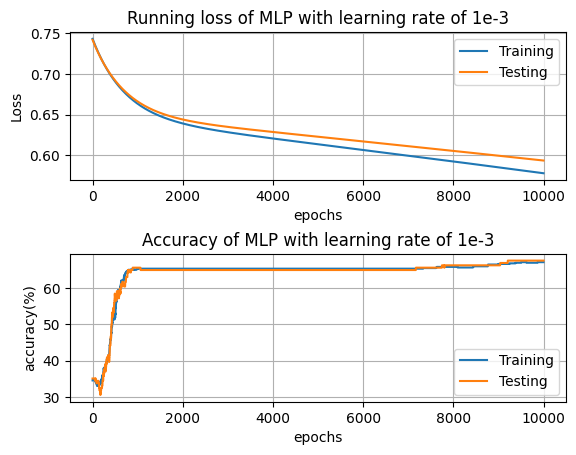

In [492]:
# learning rate w/ 1e-3
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
MLP_model6 = MLPv0(hidden_nodes).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = MLP_model6.parameters(),
                            lr = 1e-3,
                            momentum= 0,
                            weight_decay=0)

train_step(model=MLP_model6,
           X_train=X_train,
           y_train=y_train,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn,
           optimizer = optimizer,
           title = "MLP with learning rate of 1e-3")
model_eval(model=MLP_model6,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn)

In [493]:
class MLPv1(nn.Module):
  def __init__(self, hidden_nodes):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(in_features = 8, out_features = hidden_nodes),
        nn.ReLU(),
        nn.Linear(in_features = hidden_nodes, out_features = hidden_nodes),
        nn.ReLU(),
        nn.Linear(in_features = hidden_nodes, out_features = 1)
    )

  def forward(self, x: torch.Tensor):
    return self.model(x)

class MLPv2(nn.Module):
  def __init__(self, hidden_nodes):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(in_features = 8, out_features = hidden_nodes),
        nn.ReLU(),
        nn.Linear(in_features = hidden_nodes, out_features = hidden_nodes),
        nn.ReLU(),
        nn.Linear(in_features = hidden_nodes, out_features = hidden_nodes),
        nn.ReLU(),
        nn.Linear(in_features = hidden_nodes, out_features = 1)
    )

  def forward(self, x: torch.Tensor):
    return self.model(x)

  0%|          | 0/10000 [00:00<?, ?it/s]

{'model': 'MLPv0',
 'model_loss': 0.48890721797943115,
 'model_acc': 77.92207792207793}

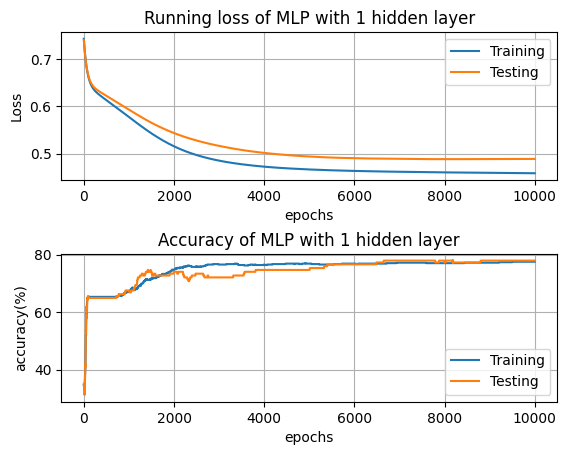

In [494]:
# with 1 hidden layer
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
MLP_model7 = MLPv0(hidden_nodes).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = MLP_model7.parameters(),
                            lr = learning_rate,
                            momentum= 0,
                            weight_decay=0)

train_step(model=MLP_model7,
           X_train=X_train,
           y_train=y_train,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn,
           optimizer = optimizer,
           title = "MLP with 1 hidden layer")
model_eval(model=MLP_model7,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn)


  0%|          | 0/10000 [00:00<?, ?it/s]

{'model': 'MLPv1',
 'model_loss': 0.4951866865158081,
 'model_acc': 78.57142857142857}

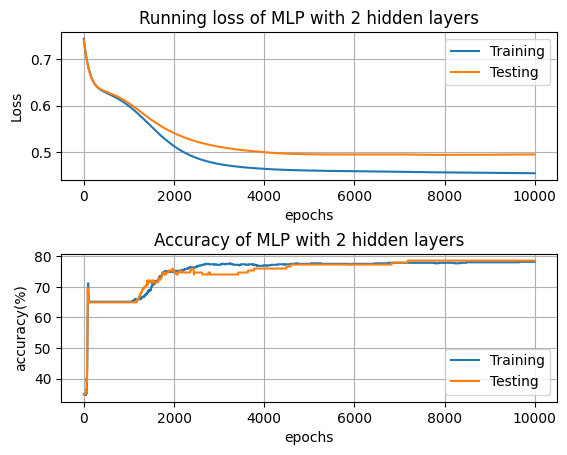

In [495]:
# with 2 hidden layers
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
MLP_model8 = MLPv1(hidden_nodes).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = MLP_model8.parameters(),
                            lr = learning_rate,
                            momentum= 0,
                            weight_decay=0)

train_step(model=MLP_model8,
           X_train=X_train,
           y_train=y_train,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn,
           optimizer = optimizer,
           title = "MLP with 2 hidden layers")
model_eval(model=MLP_model8,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn)

  0%|          | 0/10000 [00:00<?, ?it/s]

{'model': 'MLPv2',
 'model_loss': 0.49481984972953796,
 'model_acc': 77.92207792207793}

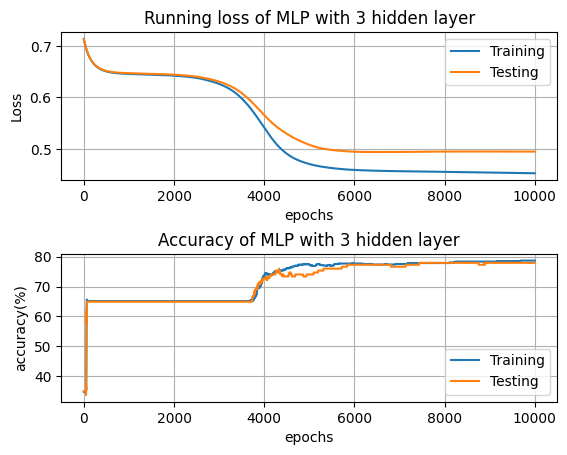

In [496]:
# with 3 hidden layers
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
MLP_model9 = MLPv2(hidden_nodes).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = MLP_model9.parameters(),
                            lr = learning_rate,
                            momentum= 0,
                            weight_decay=0)

train_step(model=MLP_model9,
           X_train=X_train,
           y_train=y_train,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn,
           optimizer = optimizer,
           title = "MLP with 3 hidden layer")
model_eval(model=MLP_model9,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn)

In [497]:
class MLPv3(nn.Module):
  def __init__(self, hidden_nodes):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(in_features = 8, out_features = hidden_nodes),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(in_features = hidden_nodes, out_features = hidden_nodes),
        nn.ReLU(),
        nn.Linear(in_features = hidden_nodes, out_features = 1)
    )

  def forward(self, x: torch.Tensor):
    return self.model(x)

class MLPv4(nn.Module):
  def __init__(self, hidden_nodes):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(in_features = 8, out_features = hidden_nodes),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(in_features = hidden_nodes, out_features = hidden_nodes),
        nn.ReLU(),
        nn.Linear(in_features = hidden_nodes, out_features = 1)
    )

  def forward(self, x: torch.Tensor):
    return self.model(x)

class MLPv5(nn.Module):
  def __init__(self, hidden_nodes):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(in_features = 8, out_features = hidden_nodes),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(in_features = hidden_nodes, out_features = hidden_nodes),
        nn.ReLU(),
        nn.Linear(in_features = hidden_nodes, out_features = hidden_nodes),
        nn.ReLU(),
        nn.Linear(in_features = hidden_nodes, out_features = 1)
    )

  def forward(self, x: torch.Tensor):
    return self.model(x)

  0%|          | 0/10000 [00:00<?, ?it/s]

{'model': 'MLPv3',
 'model_loss': 0.4951957166194916,
 'model_acc': 78.57142857142857}

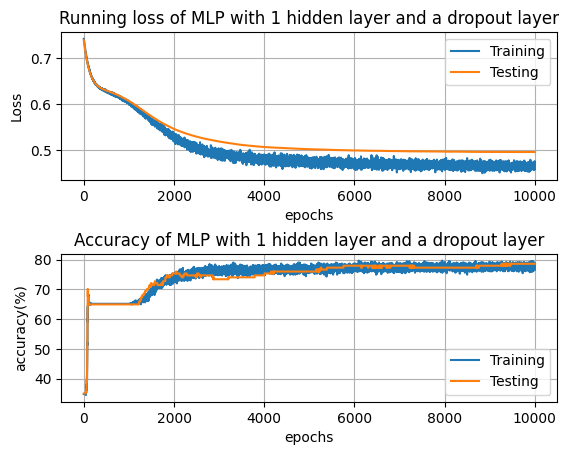

In [498]:
## w/ add 1 dropout layer in the hidden layer(p=0.1)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
MLP_model10 = MLPv3(hidden_nodes).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = MLP_model10.parameters(),
                            lr = learning_rate,
                            momentum= 0,
                            weight_decay=0)

train_step(model=MLP_model10,
           X_train=X_train,
           y_train=y_train,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn,
           optimizer = optimizer,
           title = "MLP with 1 hidden layer and a dropout layer")
model_eval(model=MLP_model10,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn)

  0%|          | 0/10000 [00:00<?, ?it/s]

{'model': 'MLPv4',
 'model_loss': 0.4951957166194916,
 'model_acc': 78.57142857142857}

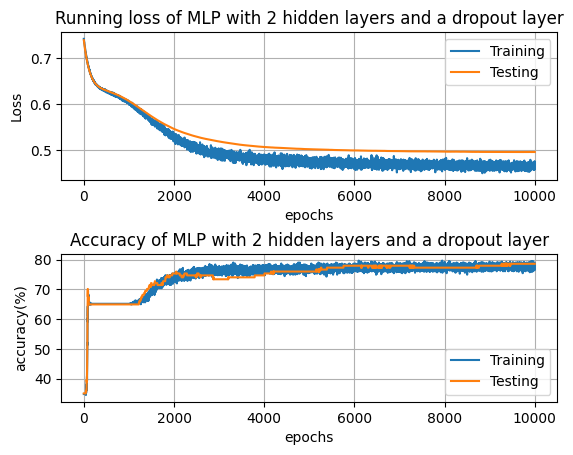

In [499]:
## w/ add 1 dropout layer in the 2 hidden layers(p=0.1)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
MLP_model11 = MLPv4(hidden_nodes).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = MLP_model11.parameters(),
                            lr = learning_rate,
                            momentum= 0,
                            weight_decay=0)

train_step(model=MLP_model11,
           X_train=X_train,
           y_train=y_train,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn,
           optimizer = optimizer,
           title = "MLP with 2 hidden layers and a dropout layer")
model_eval(model=MLP_model11,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn)

  0%|          | 0/10000 [00:00<?, ?it/s]

{'model': 'MLPv5',
 'model_loss': 0.49327266216278076,
 'model_acc': 77.92207792207793}

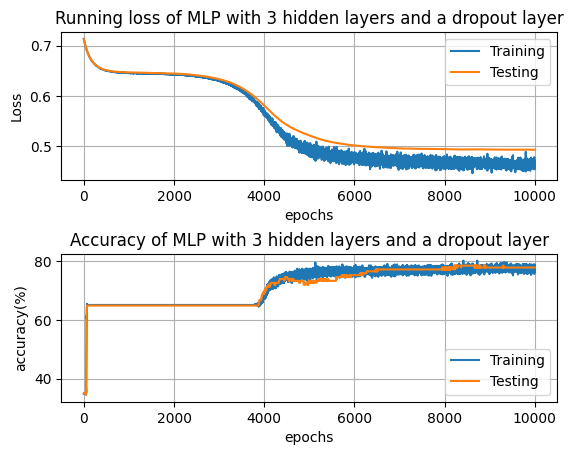

In [500]:
## w/ add 1 dropout layer in the 3 hidden layers(p=0.1)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
MLP_model12 = MLPv5(hidden_nodes).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = MLP_model12.parameters(),
                            lr = learning_rate,
                            momentum= 0,
                            weight_decay=0)

train_step(model=MLP_model12,
           X_train=X_train,
           y_train=y_train,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn,
           optimizer = optimizer,
           title = "MLP with 3 hidden layers and a dropout layer")
model_eval(model=MLP_model12,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn)

In [514]:
#######

  0%|          | 0/10000 [00:00<?, ?it/s]

{'model': 'MLPv3',
 'model_loss': 0.4951957166194916,
 'model_acc': 78.57142857142857}

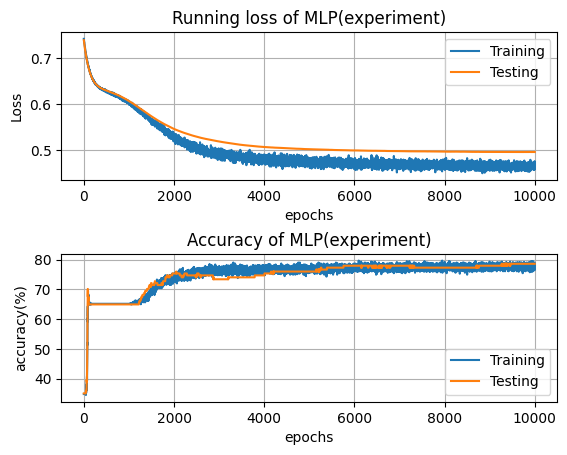

In [515]:
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
MLP_model13 = MLPv3(16).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = MLP_model13.parameters(),
                            lr = 1e-2,
                            momentum= 0.,
                            weight_decay=0.0)

train_step(model=MLP_model13,
           X_train=X_train,
           y_train=y_train,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn,
           optimizer = optimizer)
model_eval(model=MLP_model13,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn)

  0%|          | 0/10000 [00:00<?, ?it/s]

{'model': 'MLPv0',
 'model_loss': 0.48890721797943115,
 'model_acc': 77.92207792207793}

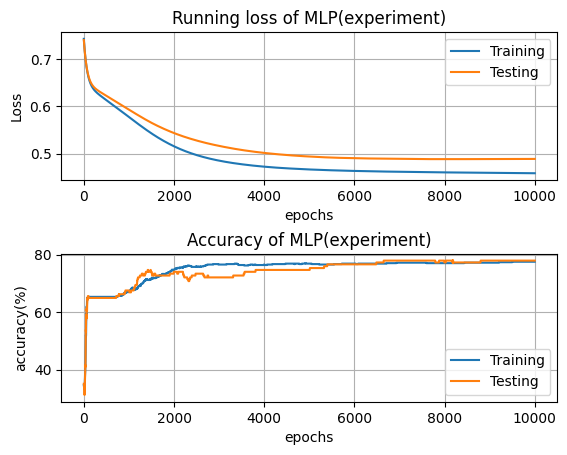

In [516]:
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
MLP_model14 = MLPv0(16).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = MLP_model14.parameters(),
                            lr = 1e-2,
                            momentum= 0.,
                            weight_decay=0.0)

train_step(model=MLP_model14,
           X_train=X_train,
           y_train=y_train,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn,
           optimizer = optimizer)
model_eval(model=MLP_model14,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn)

  0%|          | 0/10000 [00:00<?, ?it/s]

{'model': 'MLPv4',
 'model_loss': 0.4951957166194916,
 'model_acc': 78.57142857142857}

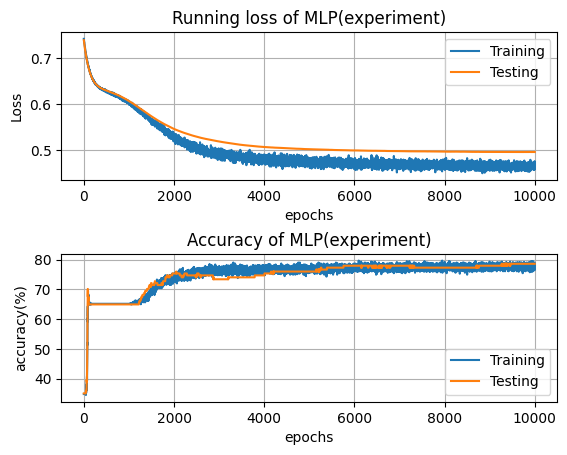

In [517]:
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
MLP_model15 = MLPv4(16).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = MLP_model15.parameters(),
                            lr = 1e-2,
                            momentum= 0.,
                            weight_decay=0.0)

train_step(model=MLP_model15,
           X_train=X_train,
           y_train=y_train,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn,
           optimizer = optimizer)
model_eval(model=MLP_model15,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn)

  0%|          | 0/10000 [00:00<?, ?it/s]

{'model': 'MLPv1',
 'model_loss': 0.4951866865158081,
 'model_acc': 78.57142857142857}

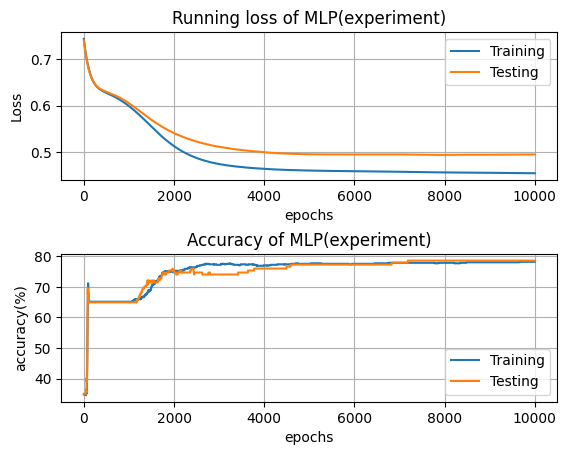

In [518]:
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
MLP_model16 = MLPv1(16).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = MLP_model16.parameters(),
                            lr = 1e-2,
                            momentum= 0.,
                            weight_decay=0.0)

train_step(model=MLP_model16,
           X_train=X_train,
           y_train=y_train,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn,
           optimizer = optimizer)
model_eval(model=MLP_model16,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn)

  0%|          | 0/10000 [00:00<?, ?it/s]

{'model': 'MLPv3',
 'model_loss': 0.47875773906707764,
 'model_acc': 77.92207792207793}

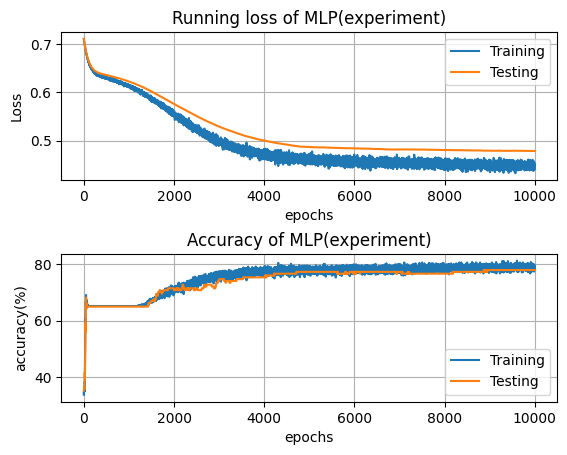

In [519]:
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
MLP_model17 = MLPv3(32).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = MLP_model17.parameters(),
                            lr = 1e-2,
                            momentum= 0.,
                            weight_decay=0.0)

train_step(model=MLP_model17,
           X_train=X_train,
           y_train=y_train,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn,
           optimizer = optimizer)
model_eval(model=MLP_model17,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn)

  0%|          | 0/10000 [00:00<?, ?it/s]

{'model': 'MLPv0',
 'model_loss': 0.48101356625556946,
 'model_acc': 77.27272727272727}

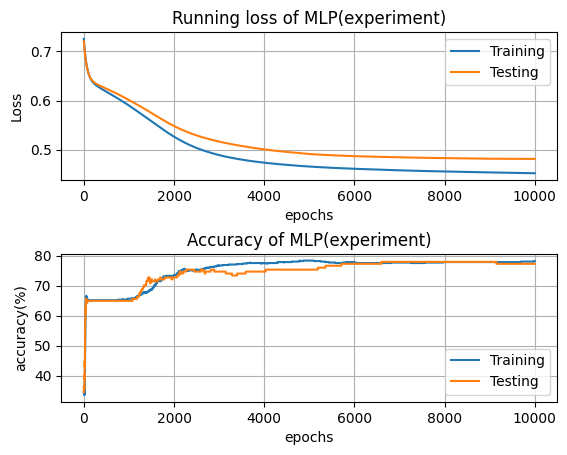

In [520]:
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
MLP_model18 = MLPv0(32).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = MLP_model18.parameters(),
                            lr = 1e-2,
                            momentum= 0.,
                            weight_decay=0.0)

train_step(model=MLP_model18,
           X_train=X_train,
           y_train=y_train,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn,
           optimizer = optimizer)
model_eval(model=MLP_model18,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn)

  0%|          | 0/10000 [00:00<?, ?it/s]

{'model': 'MLPv4',
 'model_loss': 0.47875773906707764,
 'model_acc': 77.92207792207793}

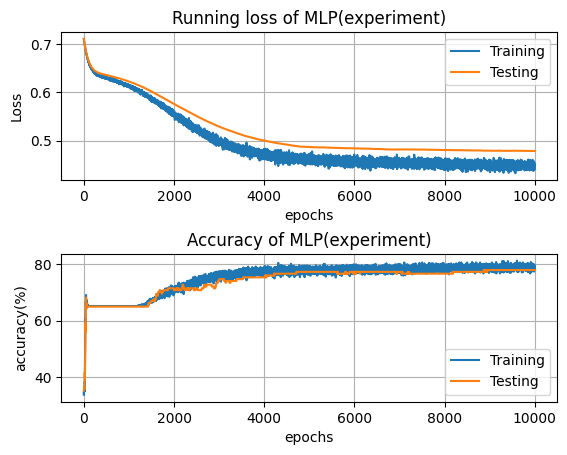

In [521]:
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
MLP_model19 = MLPv4(32).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = MLP_model19.parameters(),
                            lr = 1e-2,
                            momentum= 0.,
                            weight_decay=0.0)

train_step(model=MLP_model19,
           X_train=X_train,
           y_train=y_train,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn,
           optimizer = optimizer)
model_eval(model=MLP_model19,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn)

  0%|          | 0/10000 [00:00<?, ?it/s]

{'model': 'MLPv1',
 'model_loss': 0.47413477301597595,
 'model_acc': 78.57142857142857}

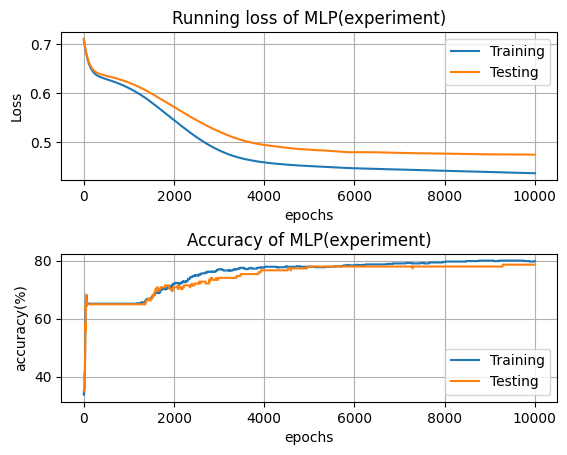

In [522]:
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
MLP_model20 = MLPv1(32).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = MLP_model20.parameters(),
                            lr = 1e-2,
                            momentum= 0.,
                            weight_decay=0.0)

train_step(model=MLP_model20,
           X_train=X_train,
           y_train=y_train,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn,
           optimizer = optimizer)
model_eval(model=MLP_model20,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn)

  0%|          | 0/10000 [00:00<?, ?it/s]

{'model': 'MLPv3',
 'model_loss': 0.4712161421775818,
 'model_acc': 77.92207792207793}

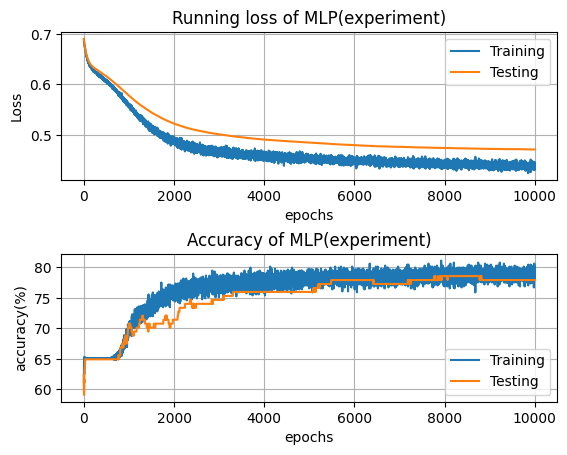

In [523]:
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
MLP_model21 = MLPv3(64).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = MLP_model21.parameters(),
                            lr = 1e-2,
                            momentum= 0.,
                            weight_decay=0.0)

train_step(model=MLP_model21,
           X_train=X_train,
           y_train=y_train,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn,
           optimizer = optimizer)
model_eval(model=MLP_model21,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn)

  0%|          | 0/10000 [00:00<?, ?it/s]

{'model': 'MLPv0',
 'model_loss': 0.47880658507347107,
 'model_acc': 77.27272727272727}

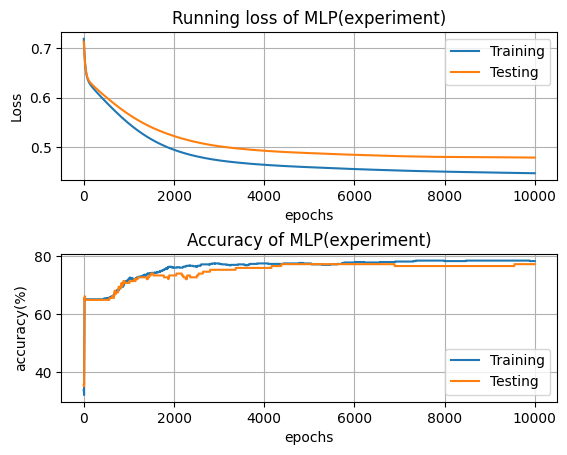

In [524]:
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
MLP_model22 = MLPv0(64).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = MLP_model22.parameters(),
                            lr = 1e-2,
                            momentum= 0.,
                            weight_decay=0.0)

train_step(model=MLP_model22,
           X_train=X_train,
           y_train=y_train,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn,
           optimizer = optimizer)
model_eval(model=MLP_model22,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn)

  0%|          | 0/10000 [00:00<?, ?it/s]

{'model': 'MLPv4',
 'model_loss': 0.4712161421775818,
 'model_acc': 77.92207792207793}

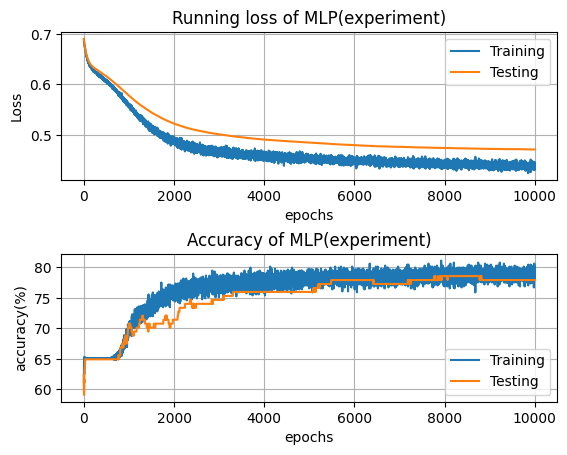

In [525]:
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
MLP_model23 = MLPv4(64).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = MLP_model23.parameters(),
                            lr = 1e-2,
                            momentum= 0.,
                            weight_decay=0.0)

train_step(model=MLP_model23,
           X_train=X_train,
           y_train=y_train,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn,
           optimizer = optimizer)
model_eval(model=MLP_model23,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn)

  0%|          | 0/10000 [00:00<?, ?it/s]

{'model': 'MLPv1',
 'model_loss': 0.47231099009513855,
 'model_acc': 77.27272727272727}

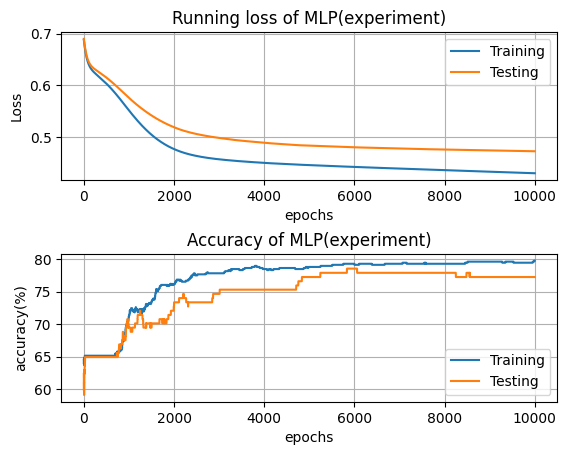

In [526]:
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
MLP_model24 = MLPv1(64).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = MLP_model24.parameters(),
                            lr = 1e-2,
                            momentum= 0.,
                            weight_decay=0.0)

train_step(model=MLP_model24,
           X_train=X_train,
           y_train=y_train,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn,
           optimizer = optimizer)
model_eval(model=MLP_model24,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn)

In [527]:
result = pd.DataFrame([model_eval(model=MLP_model13,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn),
                       model_eval(model=MLP_model14,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn),
                       model_eval(model=MLP_model15,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn),
                       model_eval(model=MLP_model16,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn),
                       model_eval(model=MLP_model17,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn),
                       model_eval(model=MLP_model18,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn),
                       model_eval(model=MLP_model19,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn),
                       model_eval(model=MLP_model20,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn),
                       model_eval(model=MLP_model21,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn),
                       model_eval(model=MLP_model22,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn),
                       model_eval(model=MLP_model23,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn),
                       model_eval(model=MLP_model24,
           X_test = X_test,
           y_test = y_test,
           loss_fn=loss_fn)])

result['hidden_nodes'] = [16,16,16,16,32,32,32,32,64,64,64,64]
result["with_a_dropout"] = [True, False, True, False,True, False, True, False,True, False, True, False]
result["no_of_hidden_layer"] = [1,1,2,2,1,1,2,2,1,1,2,2]
result = result.iloc[:,[0,5,3,4,1,2]]
result.style.format(precision=4, decimal=".")



,model,no_of_hidden_layer,hidden_nodes,with_a_dropout,model_loss,model_acc
0,MLPv3,1,16,True,0.4952,78.5714
1,MLPv0,1,16,False,0.4889,77.9221
2,MLPv4,2,16,True,0.4952,78.5714
3,MLPv1,2,16,False,0.4952,78.5714
4,MLPv3,1,32,True,0.4788,77.9221
5,MLPv0,1,32,False,0.4810,77.2727
6,MLPv4,2,32,True,0.4788,77.9221
7,MLPv1,2,32,False,0.4741,78.5714
8,MLPv3,1,64,True,0.4712,77.9221
9,MLPv0,1,64,False,0.4788,77.2727
